In [1]:
import sys
sys.path.append("../../")


from BDA.stats import *
from BDA.plots import *

now importing: 
1. numpy as np 
2. from scipy import stats


now importing: 
3. matplotlib.pyplot as plt



Consider the following data set. A population of women who were at least 21 years old, of Pima Indian heritage and living near Phoenix, Arizona, was tested for diabetes according to World Health Organization criteria. The data were collected by the US National Institute of Diabetes and Digestive and Kidney Diseases.

We're interested in calculating the posterior distribution of the rate of pregnancies for these women.

[Diabetes in Pima Indian Women](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Pima.tr.html)

In [2]:
import pandas as pd

pima = pd.read_csv("../data/Pima.csv", index_col = 0)
pima.head(10)

,npreg,glu,bp,skin,bmi,ped,age,type
1,5,86,68.0,28.0,30.2,0.364,24,No
2,7,195,70.0,33.0,25.1,0.163,55,Yes
3,5,77,82.0,41.0,35.8,0.156,35,No
4,0,165,76.0,43.0,47.9,0.259,26,No
5,0,107,60.0,25.0,26.4,0.133,23,No
6,5,97,76.0,27.0,35.6,0.378,52,Yes
7,3,83,58.0,31.0,34.3,0.336,25,No
8,1,193,50.0,16.0,25.9,0.655,24,No
9,3,142,80.0,15.0,32.4,0.200,63,No
10,2,128,78.0,37.0,43.3,1.224,31,Yes


In [3]:
pima['npreg'].describe()

count    632.000000
mean       3.628165
std        3.295201
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: npreg, dtype: float64

In [4]:
pima['npreg'].sum()

2293

In classical statistics, we'd find an estimate for $\theta$ by finding an estimate of $\theta$ that maximizes likelihood, $p(y|\theta)$.

This is done by 


First, obtain the likelihood function for $\theta$ given $y$
$$
\begin{aligned}
L(\theta | y) & = \prod_{i=1}^n p(y_i | \theta) \\
& = \prod_{i=1}^n \frac{\theta^{y_i} e^{- \theta}}{y_i !} \\
& = \theta^{\sum y_i} e^{- \sum \theta} \prod_{i=1}^n \frac{1}{y_i !} \\
& = \theta^{\sum y_i} e^{-n \theta} \prod_{i=1}^n \frac{1}{y_i !} \\
\end{aligned}
$$


Then take the (natural) log of the likelihood

$$
\begin{aligned}
log[L(\theta | y)] & = log(\theta^{\sum y_i}) + log( e^{-n \theta} ) + log( \prod_{i=1}^n \frac{1}{y_i !}) \\
& = \sum y_i log(\theta) + -n \theta + log( \prod_{i=1}^n \frac{1}{y_i !}) \\
\end{aligned}
$$


Then take the derivative of the log-likelihood and set it equal to zero in order to find the maxima

$$
\begin{aligned}
\frac{d }{d\theta} log[L(\theta | y)] & = 0 \\
\frac{\sum y_i}{\theta}  -n  & = 0\\
\hat{\theta} & = \frac{\sum y_i}{n}  = \bar{y} \\
\end{aligned}
$$



The maximum likelihood estimate for $\theta = \hat{\theta}$ is $\bar{y}$. This gives us a parameter estimate of 3.628165, but that's it. Let's compare this with the results we obtain through a Bayesian methodology.

## Noninformative Prior

Before seeing the data we had no information as to what the true value of $\theta$ might be so for this analysis we'll use a flat prior $Gamma(0.0001, 0.0001)$.

The number of samples is $n = 632$, and mean $\bar{y} = 3.628$

The posterior distribution for this problem is 

$$
\theta | y \sim Gamma(a + n \bar{y}, b + n) = Gamma(2293.0001, 632.0001)
$$


From this well defined distribution, we can obtain an estimate of $\theta$ by using the mean. The mean for a Gamma(a,b) distribution is simply $a/b$

$$
\hat{\theta} = E(\theta | y) = 2293.0001/632.0001 = 3.6281
$$


Well, we obtained the same information we would have had we simply used the MLE. So why choose the Bayesian methodology? Because we obtain a whole distribution as well!

In [5]:
## the stats module in BDA has a function `dgamma` similar to R
help(dgamma)

Help on function dgamma in module BDA.stats:

dgamma(x, shape, rate=None, scale=1, log=False)
    The Gamma distribution with parameters ‘shape’ = a and ‘scale’ = s
    has density
    
                   f(x)= 1/(s^a Gamma(a)) x^(a-1) e^-(x/s)
                   
    If you want to use a rate, simply pass `scale = 1/rate`



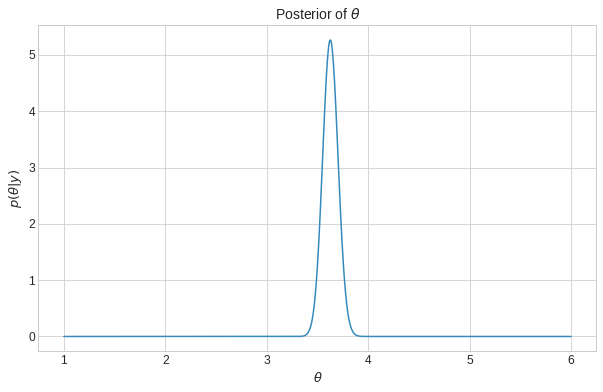

In [13]:
x = np.linspace(start=1, stop=6, num=1000)
rate = 632.0001
y = dgamma(x=x, shape=2293.0001, rate=rate)

plot(x=x, y=y, title=r"Posterior of $\theta$", xlabel=r"$\theta$", ylabel=r"$p(\theta | y)$");

## Informative Prior

Now imagine that you had some previous knowledge of this population of women. Some researcher had suggested to you that the number of pregnancies previously seen was on average 4.5 and but this did not exceed 10 and they were 95% confident of this. Well, then you'd like to take this information and apply it to your analysis!

Let's continue using the conjugate prior, Gamma(a,b). Now, let 4.5 be the mode for prior distribution and solve for a hyperparameter 

$$
\begin{aligned}
\theta_{mode} & = \frac{a-1}{b} = 4.5 \\
a = & 4.5 b
\end{aligned}
$$

We also obtained the following information

$$
\begin{aligned}
\int_0^{10} p(\theta | a,b) d\theta = 0.95 \\
= \int_0^{10} p(\theta | 1 + 4.5b, b) d\theta & = 0.95
\end{aligned}
$$


Now, with this information, we do a simple linear search for all candidates of `b` until we find one that satisfies the above conditions!

This has been provided in the function `priorGamma`

In [11]:
help(qgamma)

Help on function qgamma in module BDA.stats:

qgamma(p, shape, rate=None, scale=1, lower_tail=True)
    p: percentile (between 0 and 1)
    
    
    lower_tail: logical; if True (default), probabilities are P[X <= x],
          otherwise, P[X > x].
          
    The Gamma distribution with parameters ‘shape’ = a and ‘scale’ = s
    has density
    
                   f(x)= 1/(s^a Gamma(a)) x^(a-1) e^-(x/s)
                   
    If you want to use a rate, simply pass `scale = 1/rate`



In [12]:
help(priorGamma)

Help on function priorGamma in module BDA.stats:

priorGamma(mode, b, quantile, alpha=0.95)
    Searches for appropriate Gamma distribution
    
    mode: numeric value for mode
    b: an array of potential rate parameters
    quantile: a quantile for the Gamma distribution to match `alpha` confidence level
    alpha: confidence level (usually 0.95)
    
    Returns (shape, rate)
    To obtain scale, scale = 1/rate



In [17]:
b = np.linspace(start=0.001, stop=100, num=10000)

a, b = priorGamma(mode=4.5, b=b, quantile = 30, alpha=0.95)

print(a, b)

1.63455670567 0.14101260126


Thus, our prior distribution is $Gamma(1.635, 0.141)$ and posterior is 

$$
\theta | y \sim Gamma(2294.635, 632.141)
$$


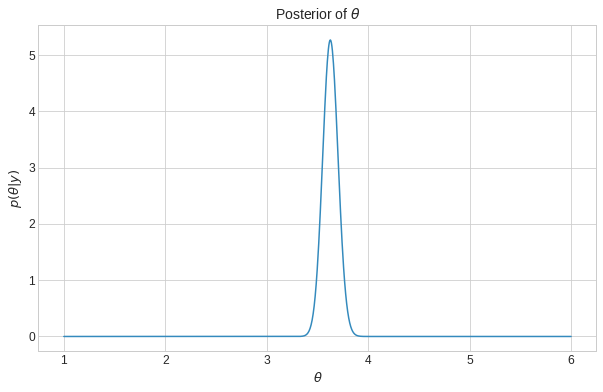

In [18]:
x = np.linspace(start=1, stop=6, num=1000)

y = dgamma(x=x, shape=2293.635, rate = 632.141)

plot(x=x, y=y, title=r"Posterior of $\theta$", xlabel=r"$\theta$", ylabel=r"$p(\theta | y)$");